In [1]:
import gc
import numpy as np
import pandas as pd
import yfinance as yf
import back_testing as bt
import matplotlib.pyplot as plt

gc.collect()

20

In [2]:
weight_df = pd.read_csv('../WRDS/Database/weight_df.csv', index_col=0)
returns_df = pd.read_csv('../WRDS/Database/returns_df.csv', index_col=0).loc[weight_df.index]
returns_df.index = pd.to_datetime(returns_df.index)
equal_weight_df = pd.DataFrame(1 / len(weight_df.columns), index=weight_df.index, columns=weight_df.columns)

In [3]:
weight_dict={}
weight_dict['Equal'] = equal_weight_df
weight_dict['Dynamic'] = weight_df

[*********************100%***********************]  1 of 1 completed

설정:
  - 기본 수수료: 0.20%
  - Turnover 배수: 1
  - 리밸런싱 주기: A


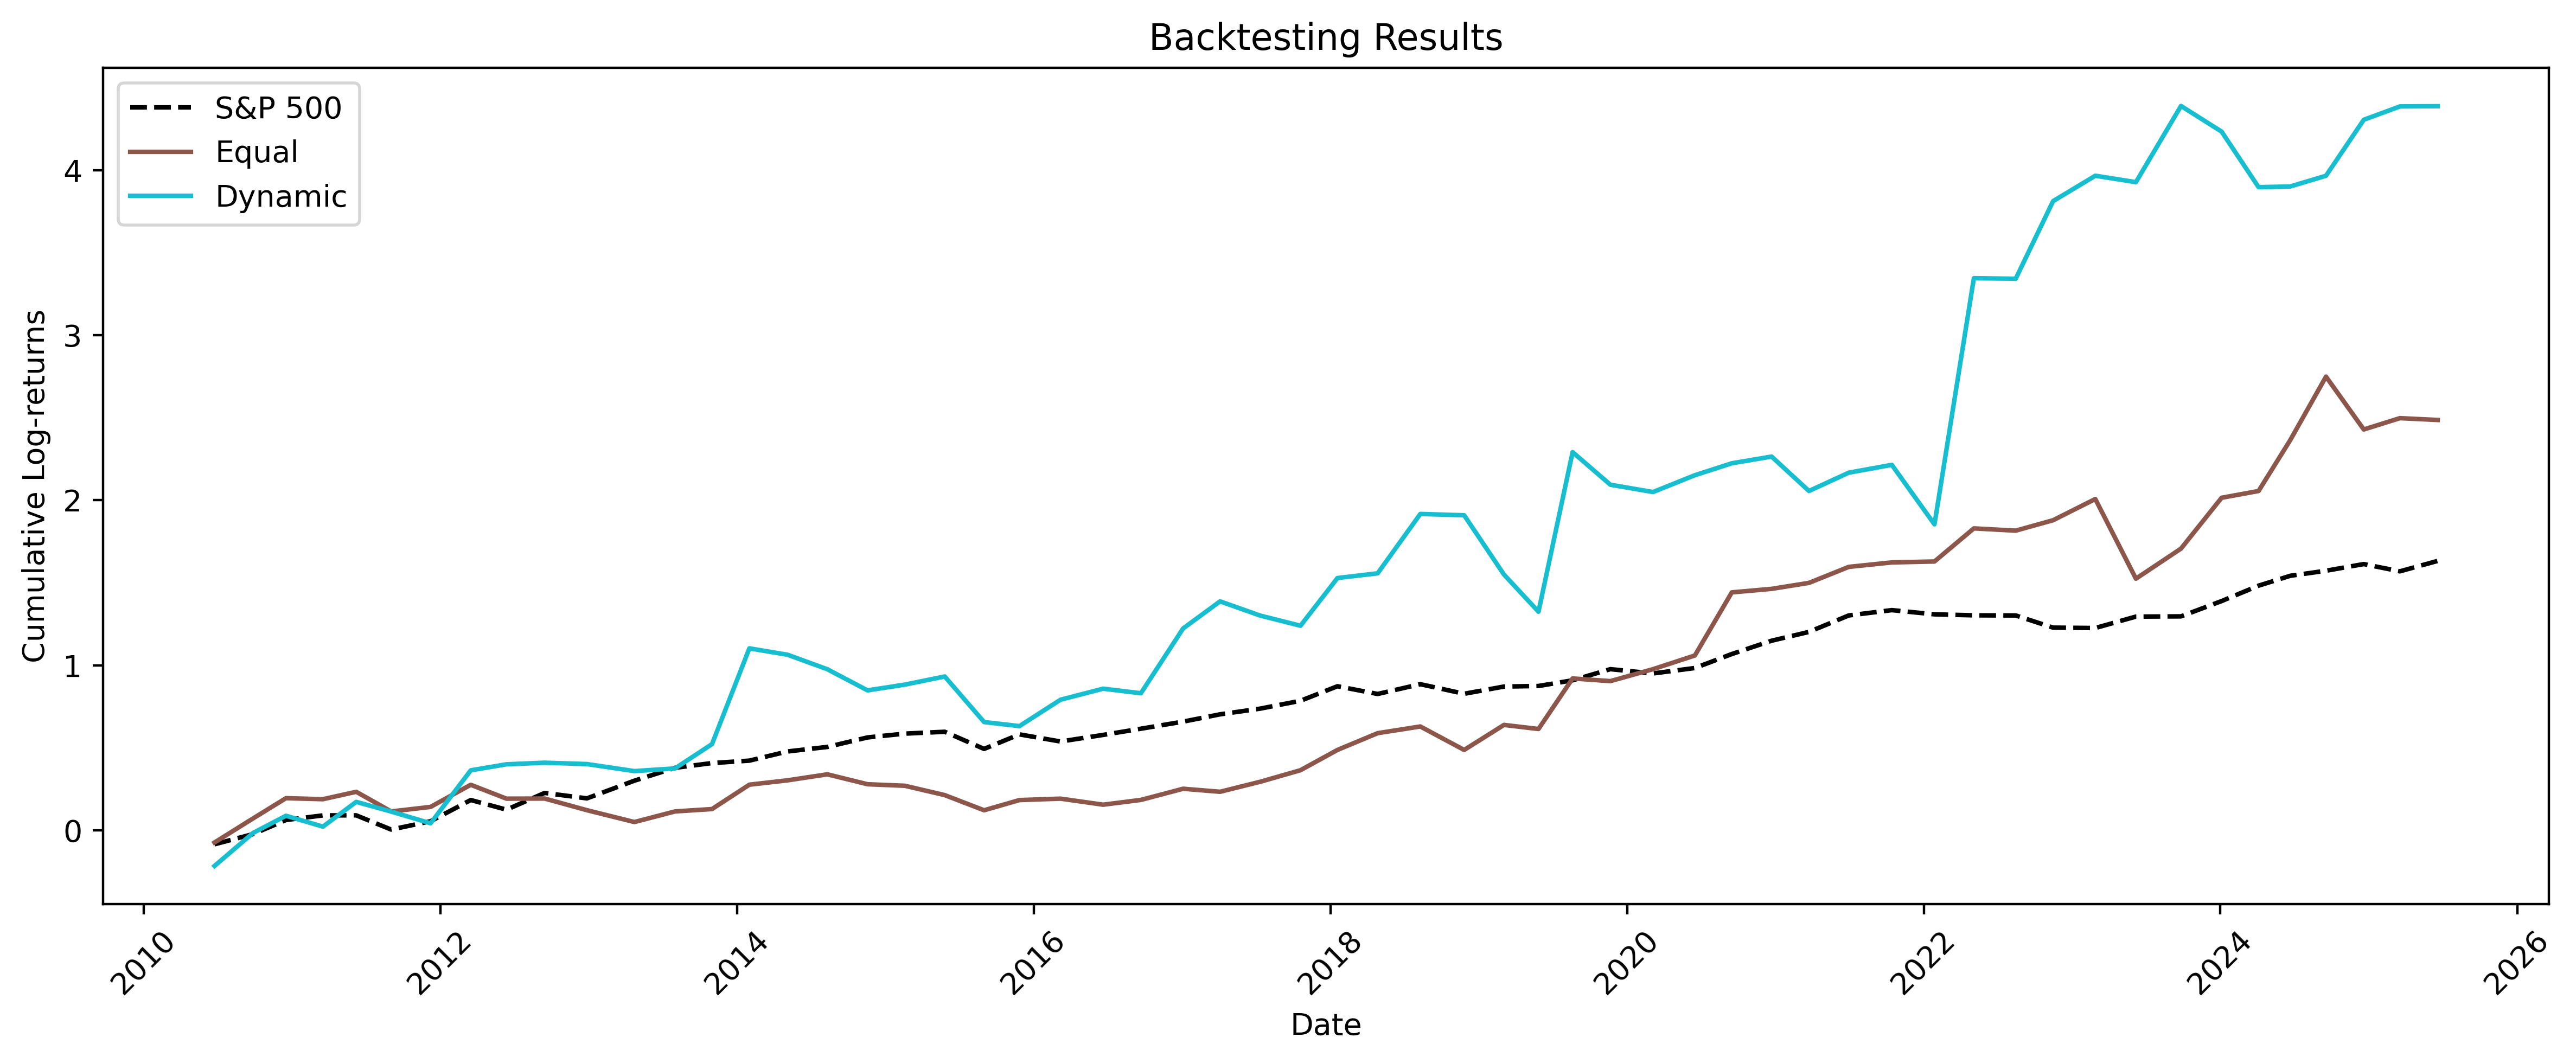

In [13]:
# 백테스팅 설정
base_fee = 0.002  # 기본 수수료 0.02%
turnover_multiplier = 1  # turnover에 따른 수수료 증가 배수
rebalance_freq = 'A' # 적응형 리벨런싱 주기

print(f"설정:")
print(f"  - 기본 수수료: {base_fee*100:.2f}%")
print(f"  - Turnover 배수: {turnover_multiplier}")
print(f"  - 리밸런싱 주기: {rebalance_freq}")

# 백테스팅 실행
result_df = pd.DataFrame()
for str_name in weight_dict.keys():
    result_df = bt.return_Table(
        weight_dict[str_name], 
        returns_df,  # 가격 데이터 직접 전달
        result_df,
        rebalance_freq=rebalance_freq,
        fee=base_fee,
        turnover_multiplier=turnover_multiplier
    )
    
# 컬럼명 설정 (S&P 500 + 전략들)
result_df.columns = ['S&P 500'] + list(weight_dict.keys())

bt.plot_result(result_df)

In [14]:
freq = 'A'
# turnover 계산 (예: 월별 리밸런스)
turnover_per_period = bt.cal_turnover(weight_dict['Dynamic'], rebalance_freq=freq)

# 수수료 효과 계산
fee_log = bt.cal_dynamic_fee(turnover_per_period, fee=0.002, turnover_multiplier=1)

# 총 수수료 (log-return 기준 합산)
total_fee = fee_log.sum()
print(f"{freq} turnover_mean: {turnover_per_period.mean():.4f}")
print(f"{freq} 총 수수료 (log return 합): {total_fee:.4f}")


A turnover_mean: 0.8311
A 총 수수료 (log return 합): -0.2145


In [6]:
metric = bt.METRICS(result_df.dropna())
metric.cal_describe()
metric.cal_monthly_statistics()

In [7]:
metric.annual_statistics

,S&P 500,Equal,Dynamic
Date,2010-06-24 ~ 2025-06-19,2010-06-24 ~ 2025-06-19,2010-06-24 ~ 2025-06-19
count,58,58,58
cumulative return,411.43462,1167.47552,12100.64875
annualized return mean,0.11913,0.19142,0.3928
annualized return std,0.11292,0.3254,0.80326
annualized return downside std,0.06333,0.26446,0.25387
sharpe ratio,1.05503,0.58825,0.489
sortino ratio,1.8811,0.7238,1.54727
gross profit,2.32575,4.19649,7.64229
gross loss,-0.6937,-1.65688,-2.83821


In [8]:
metric.monthly_statistics

,S&P 500,Equal,Dynamic
Mean,0.02814,0.04379,0.08283
Standard deviation,0.05349,0.14086,0.2948
Standard error,0.00709,0.01866,0.03905
t-statistic,4.7544,2.953,2.9076
Min,-0.10394,-0.48281,-0.3571
25%,-0.00046,-0.01556,-0.0521
50%,0.03611,0.03627,0.02594
75%,0.06284,0.10046,0.15289
Max,0.1289,0.38467,1.49526
Skew,-0.60113,-0.44893,2.37613


In [9]:
metric.save_results('./general_results')